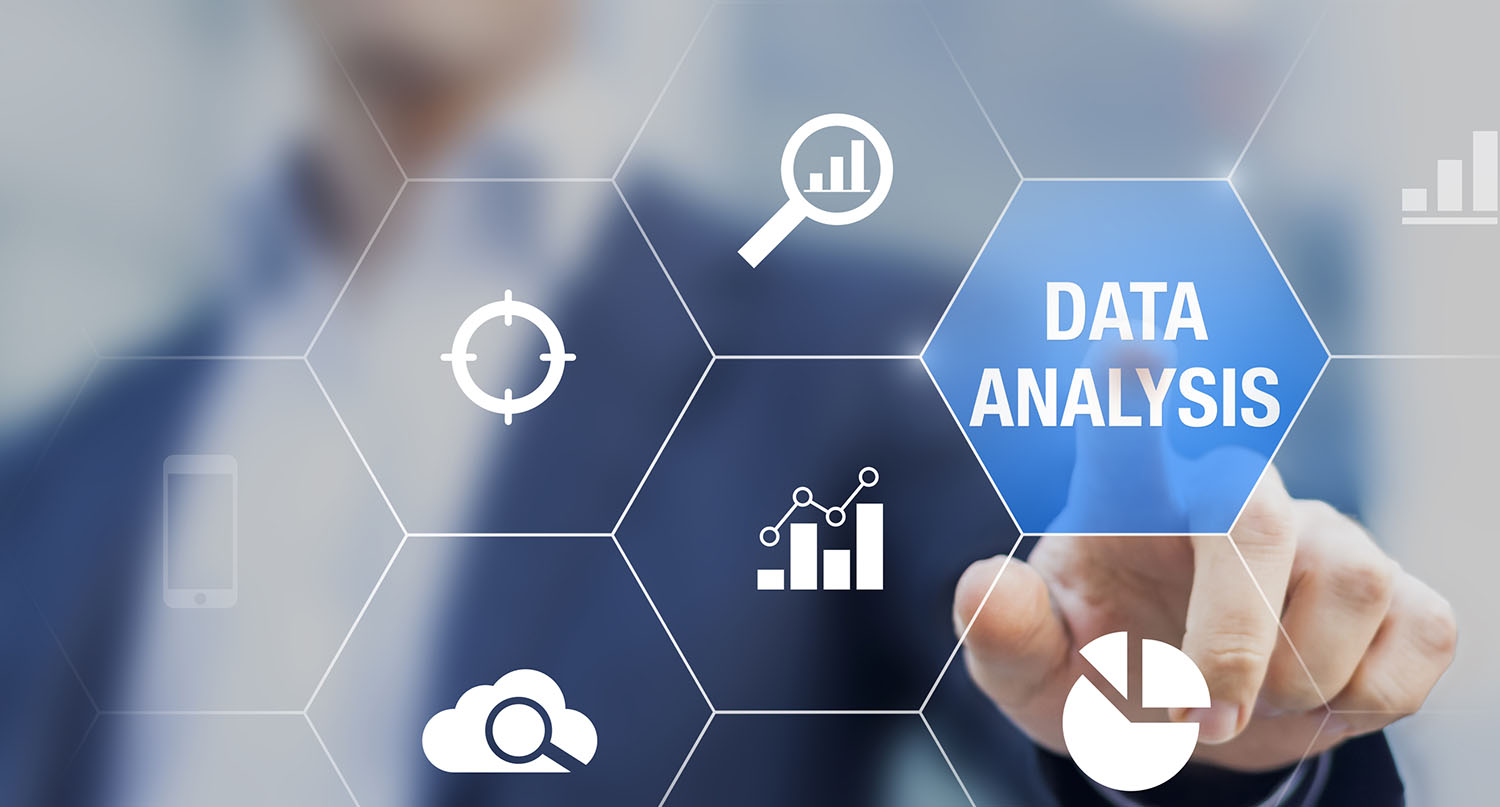




### Вводная часть
#### 1. Легенда

Итак, я работаю аналитиком в онлайн-школе MasterMind.

Уже в конце рабочего дня мне пишет расстроенный продакт-менеджер. Несчастный Григорий крайне устал от того, что новые курсы, созданные с той же любовью, что и прежние, не пользуются особой популярностью среди пользователей — несмотря на все усилия отдела маркетинга.

#### 2. Цель

Подготовить основу рекомендательной системы.

#### 3. Задачи

Итак, продакт ожидает получить от меня рекомендательную систему, благодаря которой можно будет предлагать клиентам интересные им курсы и тем самым повышать средний чек.

Я решаетю, что изначальным воплощением этой системы может стать таблица, в которой курсам будет соответствовать по две рекомендации.

Кроме того, я планирую вместе с отчётом (таблицей рекомендаций) скинуть продакту ещё и все написанные в процессе скрипты, чтобы было меньше вопросов по решению :) Ну, и раз в код будут смотреть не только мои глаза, я считаю необходимым снабдить его комментариями, которые бы разъясняли, что где и почему я делаю.

Также я понимаю, что перед внедрением фичи коллеги решат провести A/B-тест и меня скорее всего привлекут к анализу результатов.

Перспективы ясны, можно переходить к формализации задач.

#### 4. Формализованные задачи

Обдумав план предстоящей работы, я понимаю, что действовать нужно по привычной схеме:
- Познакомиться с датасетом, подготовить и проанализировать данные с помощью SQL.
- Обработать данные средствами Python.
- Составить итоговую таблицу с рекомендациями, снабдив её необходимыми комментариями, и представить отчёт продакт-менеджеру.
- Проанализировать результаты A/B-теста, проведённого после внедрения фичи, и сделать вывод.

#### 5. Результат

Итогом работы станет файл, содержащий результаты всех промежуточных этапов: скрипты с комментариями, таблица рекомендаций и выводы.

### Знакомство с данными. Первичый анализ.
Скачала данные, просмотрела их в Metabase с помощью SQL-запросов.

Данные представлены в 2 таблицах carts и cart items. Столбцом, по которому могу объединить таблицы (primary key) является столбец с id корзины: в таблице cart столбец "id", в таблице cart items - столбец "cart_id".

Произвела объединение таблиц, сформировала таблицу купленных курсов в разрезе пользователей, отфильтровала ее по покупателям, которые купили 2 курса и более.

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import psycopg2
import psycopg2.extras

In [2]:
#Подключила базу данных через pgAdmin
try:
    connection = psycopg2.connect(
        user="skillfactory",
        password="cCkxxLVrDE8EbvjueeMedPKt",
        host="84.201.134.129",
        port="5432",
        database="skillfactory",
    )
    cursor = connection.cursor()
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("You are connected to - ", record[0], "\n")
except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL", error)
finally:
    if connection:
        cursor.close()
        connection.close()
        print("PostgreSQL connection is closed")

You are connected to -  PostgreSQL 11.3 (Debian 11.3-1.pgdg90+1) on x86_64-pc-linux-gnu, compiled by gcc (Debian 6.3.0-18+deb9u1) 6.3.0 20170516, 64-bit 

PostgreSQL connection is closed


In [3]:
#Сделала SQL-запрос напрямую из базы посредством Python, используя коннект выше.
def getData():
    query = '''
WITH users_purchases AS
(
SELECT
    c.user_id,
    c.state,
    ci.cart_id,
    ci.resource_type,
    ci.resource_id,
    c.purchased_at,
    c.updated_at
FROM final.carts c
JOIN final.cart_items ci ON c.id=ci.cart_id
WHERE state='successful' AND resource_type='Course'
),
clients AS
(
SELECT user_id,
    COUNT(DISTINCT resource_id) as count_courses
FROM users_purchases up
GROUP BY user_id
HAVING COUNT(DISTINCT resource_id)>1
)
SELECT
    distinct(user_id),
    resource_id
FROM users_purchases
WHERE user_id IN
(
    SELECT
        user_id
        FROM
             clients
             )
    '''.format()
    conn = psycopg2.connect(dbname='skillfactory',
                            user='skillfactory',
                            host='84.201.134.129',
                            password='cCkxxLVrDE8EbvjueeMedPKt',
                            port=5432)
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    dict_cur.close()
    conn.close()
    return data
df=pd.DataFrame(getData())

Результатом запроса стал датафрейм, получила информацию о нем.

In [4]:
df = pd.DataFrame(getData())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34074 entries, 0 to 34073
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      34074 non-null  int64
 1   resource_id  34074 non-null  int64
dtypes: int64(2)
memory usage: 532.5 KB


In [6]:
# для удобства переименовала столбцы
df.rename(columns={'user_id':'users', 'resource_id':'resources'},inplace=True)

# отсортировала таблицу в порядке возрастания по обоим столбцам, так можно будет наглядно увидеть, что одному пользователю соответствует несколько курсов
df = df.sort_values(by=['users', 'resources'], ascending=[True, True], ignore_index=True)
df.head()

,users,resources
0,51,516
1,51,1099
2,6117,356
3,6117,357
4,6117,1125


In [7]:
# Сгуппировала датафрейм по пользователям и получила в столбце users пльзователей, купивших курсы, а в столбце resources - список курсов
df_group = df.groupby('users')['resources'].apply(list).reset_index()
df_group.head()

,users,resources
0,51,"[516, 1099]"
1,6117,"[356, 357, 1125]"
2,10275,"[553, 1147]"
3,10457,"[361, 1138]"
4,17166,"[356, 357]"


In [8]:
df_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12656 entries, 0 to 12655
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   users      12656 non-null  int64 
 1   resources  12656 non-null  object
dtypes: int64(1), object(1)
memory usage: 197.9+ KB


Просмотрела инфомацию о полученной таблице. Количество строк совпало с количеством покупателей курсов, которое я получила в первоначальном SQL-запросе в Metabase - 12656.

Теперь нужно разбить купленные курсы по парам и ранжировать их по частоте выбора.

In [9]:
#Для начала выявляю все возможные комбинации из наборов купленных курсов 
from itertools import combinations #воспользуюсь возможностями этого модуля из стандартной библиотеки Pandas
couple_courses = [] #создаю пустой список для пар курсов
for i in df_group.resources:
    for j in combinations(i,2):
        couple_courses.append(j)

from collections import Counter 
#воспользуюсь возможностями этого модуля для подсчета количества пар и выстраивания их в порядке убывания
#встречаемости
couple_count = Counter(couple_courses).most_common()   
couple_count  

[((551, 566), 797),
 ((515, 551), 417),
 ((489, 551), 311),
 ((523, 551), 304),
 ((566, 794), 290),
 ((489, 515), 286),
 ((490, 566), 253),
 ((490, 551), 247),
 ((570, 752), 247),
 ((569, 572), 216),
 ((515, 523), 213),
 ((553, 745), 212),
 ((489, 523), 206),
 ((569, 840), 204),
 ((514, 551), 200),
 ((516, 745), 199),
 ((515, 566), 195),
 ((489, 566), 188),
 ((504, 572), 184),
 ((572, 840), 178),
 ((551, 552), 177),
 ((507, 570), 172),
 ((490, 809), 163),
 ((489, 490), 152),
 ((507, 752), 150),
 ((523, 552), 144),
 ((490, 515), 143),
 ((551, 570), 142),
 ((504, 569), 139),
 ((514, 515), 139),
 ((551, 745), 138),
 ((514, 566), 138),
 ((502, 551), 135),
 ((504, 840), 135),
 ((571, 1125), 122),
 ((502, 566), 120),
 ((523, 566), 120),
 ((570, 809), 119),
 ((752, 809), 115),
 ((490, 523), 114),
 ((357, 571), 112),
 ((523, 564), 110),
 ((551, 749), 109),
 ((516, 553), 107),
 ((551, 777), 107),
 ((551, 679), 104),
 ((356, 571), 103),
 ((551, 564), 103),
 ((515, 749), 103),
 ((568, 745), 102),

In [10]:
#Получила количество таких пар
len(couple_count)

3989

Изучая полученный список кортежей, вижу, что примерно от середины списка частотность покупки резко уменьшается до однозначных чисел, что свидетельствует о частотности близкой к случайности. Поэтому решила определить минимальный порог частотности.

Для этого создала из полученного списка датафрейм и проанализировала его методом describe().

In [11]:
df_courses =  pd.DataFrame(couple_count)
df_courses.columns = ['couples', 'frequency']
df_courses.describe()

,frequency
count,3989.000000
mean,10.031838
std,26.355998
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,797.000000


Получаю среднее значение частотности 10 и 75%-квантиль, равный 9.

Поэтому я выбираю минимальную частотность 9, по этой частоте отфильтрую количество пар  для рекомендаций.

In [12]:
#Для создания таблицы рекомендаций курсов мне понадобится список уникальных номеров купленных курсов
uniq_course = df.resources.unique()
uniq_course = list(uniq_course)

#А так же понадобится преобразовать список couple_count в словарь, где ключами будут возможные пары курсов, 
# а значениями - частота их встречаемости.
courses_dict = dict(couple_count)

#Отфильтровываю пары с частотностью менее 9 раз
courses = {key:value for key, value in courses_dict.items() if value > 9}
courses

{(551, 566): 797,
 (515, 551): 417,
 (489, 551): 311,
 (523, 551): 304,
 (566, 794): 290,
 (489, 515): 286,
 (490, 566): 253,
 (490, 551): 247,
 (570, 752): 247,
 (569, 572): 216,
 (515, 523): 213,
 (553, 745): 212,
 (489, 523): 206,
 (569, 840): 204,
 (514, 551): 200,
 (516, 745): 199,
 (515, 566): 195,
 (489, 566): 188,
 (504, 572): 184,
 (572, 840): 178,
 (551, 552): 177,
 (507, 570): 172,
 (490, 809): 163,
 (489, 490): 152,
 (507, 752): 150,
 (523, 552): 144,
 (490, 515): 143,
 (551, 570): 142,
 (504, 569): 139,
 (514, 515): 139,
 (551, 745): 138,
 (514, 566): 138,
 (502, 551): 135,
 (504, 840): 135,
 (571, 1125): 122,
 (502, 566): 120,
 (523, 566): 120,
 (570, 809): 119,
 (752, 809): 115,
 (490, 523): 114,
 (357, 571): 112,
 (523, 564): 110,
 (551, 749): 109,
 (516, 553): 107,
 (551, 777): 107,
 (551, 679): 104,
 (356, 571): 103,
 (551, 564): 103,
 (515, 749): 103,
 (568, 745): 102,
 (356, 357): 100,
 (363, 511): 99,
 (551, 571): 98,
 (551, 809): 96,
 (502, 514): 95,
 (551, 794): 

In [13]:
#количество оставшихся пар, их оказалось почти в 4 раза меньше
len(courses)

928

Теперь можно приступать к заполнению таблицы.

In [14]:
#Создаю функцию для заполнения списка рекомендаций
def recommendation(id):
    recomm_list = [] #Создаю пустой список 
    for i in courses.keys():
        if i[0] == id:
            recomm_list.append((i, courses[i]))
        elif i[1] == id:
            recomm_list.append((i, courses[i]))
    recomm_list_sort = sorted(recomm_list, key=lambda x:x[1], reverse=True)
    return recomm_list_sort[:2]  

In [15]:
recommendation(752) #проверила действие функции

[((570, 752), 247), ((507, 752), 150)]

In [16]:
#Создаю датафрейм для заполнения
final_recommend = pd.DataFrame(columns=['course_id', 'recomm_one', 'recomm_two'])
#С помощью функции и списка уникальных проданых курсов заполняю таблицу с рекомендациями:
for i in uniq_course: 
    if len(recommendation(i)) == 2:
        final_recommend.loc[i] = [i, recommendation(i)[0][0][1], recommendation(i)[1][0][1]]
    elif len(recommendation(i)) == 1:
        final_recommend.loc[i] = [i, recommendation(i)[0][0][1], 'null']
    else:
        final_recommend.loc[i] = [i, 'null', 'null']
final_recommend = final_recommend.sort_values(by='course_id', ascending=True).reset_index(drop=True)

final_recommend

,course_id,recomm_one,recomm_two
0,356,571,357
1,357,571,357
2,358,570,752
3,359,570,359
4,360,745,516
...,...,...,...
121,1188,1188,1188
122,1198,null,null
123,1199,null,null
124,1200,null,null


In [17]:
#Получаю информацию о датафрейме
final_recommend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   course_id   126 non-null    int64 
 1   recomm_one  126 non-null    object
 2   recomm_two  126 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.1+ KB


Таблица получилась не совсем корректная:
- невозможно посчитать количество отсутствующих рекомендаций;
- к некоторым курсам рекомендованы точно такие же в допродажу.

Первый пункт возможно исправить, если заполнять отсутствующие рекомендации вместо 'null' специальным значением из библиотеки NumPy - np.nan.

In [18]:
#Проверяю работу функции на одном элементе, к которому в таблице даны одинаковые рекомендации
recommendation(1188)

[((1141, 1188), 15), ((513, 1188), 11)]

На одном элементе функция работает корректно, но заполнение рекомендаций некорректно.

Все дело в том, что я прописала для 2-х рекомендаций только вариант, когда первый рекомендуемый курс находится на первом месте в первой паре курсов и второй - на втором месте во второй паре курсов. Но это не единственный вариант. 

Вариантов для 2-х рекомендаций может быть 4:
- recommendation(i)[0][0][1], recommendation(i)[1][0][1];
- recommendation(i)[0][0][1], recommendation(i)[1][0][0];
- recommendation(i)[0][0][0], recommendation(i)[1][0][1];
- recommendation(i)[0][0][0], recommendation(i)[1][0][0].

А также для 1-й рекомендации так же могут быть 2 варианта:
- recommendation(i)[0][0][1];
- recommendation(i)[0][0][0].

In [19]:
#Поэтому добавила в код еще варианты:
final_recommend_1 = pd.DataFrame(columns=['course_id', 'recomm_one', 'recomm_two'])

for i in uniq_course: 
    if len(recommendation(i)) == 2:
        if (i == recommendation(i)[0][0][0]) and (i == recommendation(i)[1][0][0]):
            final_recommend_1.loc[i] = [i, recommendation(i)[0][0][1], recommendation(i)[1][0][1]]  
        elif (i == recommendation(i)[0][0][0]) and (i == recommendation(i)[1][0][1]):
            final_recommend_1.loc[i] = [i, recommendation(i)[0][0][1], recommendation(i)[1][0][0]]
        elif (i == recommendation(i)[0][0][1]) and (i == recommendation(i)[1][0][0]):
            final_recommend_1.loc[i] = [i, recommendation(i)[0][0][0], recommendation(i)[1][0][1]]
        elif (i == recommendation(i)[0][0][1]) and (i == recommendation(i)[1][0][1]):
            final_recommend_1.loc[i] = [i, recommendation(i)[0][0][0], recommendation(i)[1][0][0]]                 
    elif len(recommendation(i)) == 1:
        if i == recommendation(i)[0][0][0]:
            final_recommend_1.loc[i] = [i, recommendation(i)[0][0][1], np.nan]
        if i == recommendation(i)[0][0][1]:
            final_recommend_1.loc[i] = [i, recommendation(i)[0][0][0], np.nan]
    else:
        final_recommend_1.loc[i] = [i, np.nan, np.nan]
final_recommend_1 = final_recommend_1.sort_values(by='course_id', ascending=True).reset_index(drop=True)

final_recommend_1

,course_id,recomm_one,recomm_two
0,356.0,571.0,357.0
1,357.0,571.0,356.0
2,358.0,570.0,752.0
3,359.0,570.0,358.0
4,360.0,745.0,516.0
...,...,...,...
121,1188.0,1141.0,513.0
122,1198.0,NaN,NaN
123,1199.0,NaN,NaN
124,1200.0,NaN,NaN


Теперь вижу, что рекомендации заполняются более корректно, но остались незаполненные значения NaN. 

Но теперь есть возможность посчитать количество отсутствующих рекомендаций. Для этого получаю информацию о датафрейме.

In [20]:
final_recommend_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   course_id   126 non-null    float64
 1   recomm_one  104 non-null    float64
 2   recomm_two  97 non-null     float64
dtypes: float64(3)
memory usage: 3.1 KB


В столбце первых рекомендаций отсутствует 22 значения, во втором - 29.

Просто заполнить нулевыми значениями не имеет смысла, приняла решение, что нужно заполнять рандомно из списка самых востребованных курсов с помощью функции random.choice

In [21]:
#Создаю счетчик самых популярных пар проданных курсов:
couple_pop = Counter(couple_courses).most_common(9)
couple_pop

[((551, 566), 797),
 ((515, 551), 417),
 ((489, 551), 311),
 ((523, 551), 304),
 ((566, 794), 290),
 ((489, 515), 286),
 ((490, 566), 253),
 ((490, 551), 247),
 ((570, 752), 247)]

In [22]:
#Из счетчика создаю список пар с частотой их повторений
coup_pop_list = list(couple_pop)
coup_pop_list

[((551, 566), 797),
 ((515, 551), 417),
 ((489, 551), 311),
 ((523, 551), 304),
 ((566, 794), 290),
 ((489, 515), 286),
 ((490, 566), 253),
 ((490, 551), 247),
 ((570, 752), 247)]

In [23]:
#Теперь создаю список только курсов, без пар
pop_list = []
for row in coup_pop_list:
    pop_list.append(row[0][0])
    pop_list.append(row[0][1])
print(pop_list)

[551, 566, 515, 551, 489, 551, 523, 551, 566, 794, 489, 515, 490, 566, 490, 551, 570, 752]


Можно бы было использовать этот список, но в нем повторяются курсы, что приведет к дублированию рекомендаций. Поэтому избавляюсь от дублей через set().

In [24]:
#Удаляю дубликаты      
list_pop = list(set(pop_list))
list_pop

[515, 551, 489, 490, 523, 752, 570, 566, 794]

In [25]:
#Создаю цикл для замены значений NaN на один из курсов из списка самых продаваемых курсов
for i in range(len(final_recommend_1)):
    if np.isnan(final_recommend_1.loc[i][1]):
        final_recommend_1.loc[i][1] = np.random.choice(list_pop)
    elif np.isnan(final_recommend_1.loc[i][2]):
        final_recommend_1.loc[i][2] = np.random.choice(list_pop)
        
final_recommend_1

,course_id,recomm_one,recomm_two
0,356.0,571.0,357.0
1,357.0,571.0,356.0
2,358.0,570.0,752.0
3,359.0,570.0,358.0
4,360.0,745.0,516.0
...,...,...,...
121,1188.0,1141.0,513.0
122,1198.0,489.0,NaN
123,1199.0,515.0,NaN
124,1200.0,489.0,NaN


И наконец получаю искомую таблицу с рекомендованными для допродажи курсами.

### А/В-тестрирование
Спустя месяц на сайте появляется новая функциональность — та самая, в подготовке которой я участвовала. Теперь пользователи могут получать предложения добавить в корзину ещё курсы, которые могли бы им подойти.

Но прежде чем примеенять рекомендательную систему для всех пользователей, коллеги хотят оценить эффективность этой функции и качество подбора рекомендаций.

Для этого запускается А/В-тест.

Для тестирования необходимо было взять не менее 7900 покупателей в группу, согласно онлайн-калькулятора Эвана-Миллера (при уровне достоверности 95% и статистической мощности 80%).

До реализации рекомендаций средняя конверсия в покупку второго курса была 3,2%. Я ожидаю, что ввод рекомендаций сможет поднять её до 4%.

Прошло три недели...

Каждый из вариантов A/B-теста достиг необходимого размера выборки, и теперь мне необходимо сделать вывод, можно ли считать реализацию рекомендательной системы успешной, и принять решение о полезности её внедрения.

Численное выражение полученных результатов таково:
1. В контрольной группе оказалось 8732 клиента, оформивших заказ, из них 293 купили больше одного курса.
2. В тестовой — 8847 клиентов, из них 347 купили больше одного курса.
3. Расчетное значение p-value - 0,022 (при использовании онлайн-калькулятора).

In [26]:
#Рассчитываю p-value "вручную"
import math as mth
from math import sqrt
from scipy import stats as st
#Тестирование провожу с уронем статистической значимости 0,05
n_A = 8732
n_B = 8847
π1 = π2 = 0.5
x_A = 293 
x_B = 347
p1 = x_A / n_A
p2 = x_B / n_B
a = .05
#применяю формулу для определения z-статистики (одностороннюю)
p = (x_A + x_B) / (n_A + n_B) 
diff = p1 - p2 
z = diff / mth.sqrt(p * (1 - p) * (1/n_A + 1/n_B))
distr = st.norm(0, 1)
#Рассчитываю p-value:
p_val = (1 - distr.cdf(abs(z))) 
p_val

0.02243159896524971

Какой вывод вы можете сделать по итогу эксперимента?
1. Вариант с рекомендациями показал статистически значимо лучший результат, нужно реализовывать его для всех клиентов.

## Выводы
И так, основной вывод .....наши Беня Шерлокович Холмсов и Григорий Батькович Лестредов (в легенде не указано, как продакт по батюшке будет) реально оба устали, причем сильно. Но Беня не был бы Беней, если бы не повзвал своего <s>братюню</s> коллегу Светозара Кирыча Ягамова (Yagami Light, Death Note). 
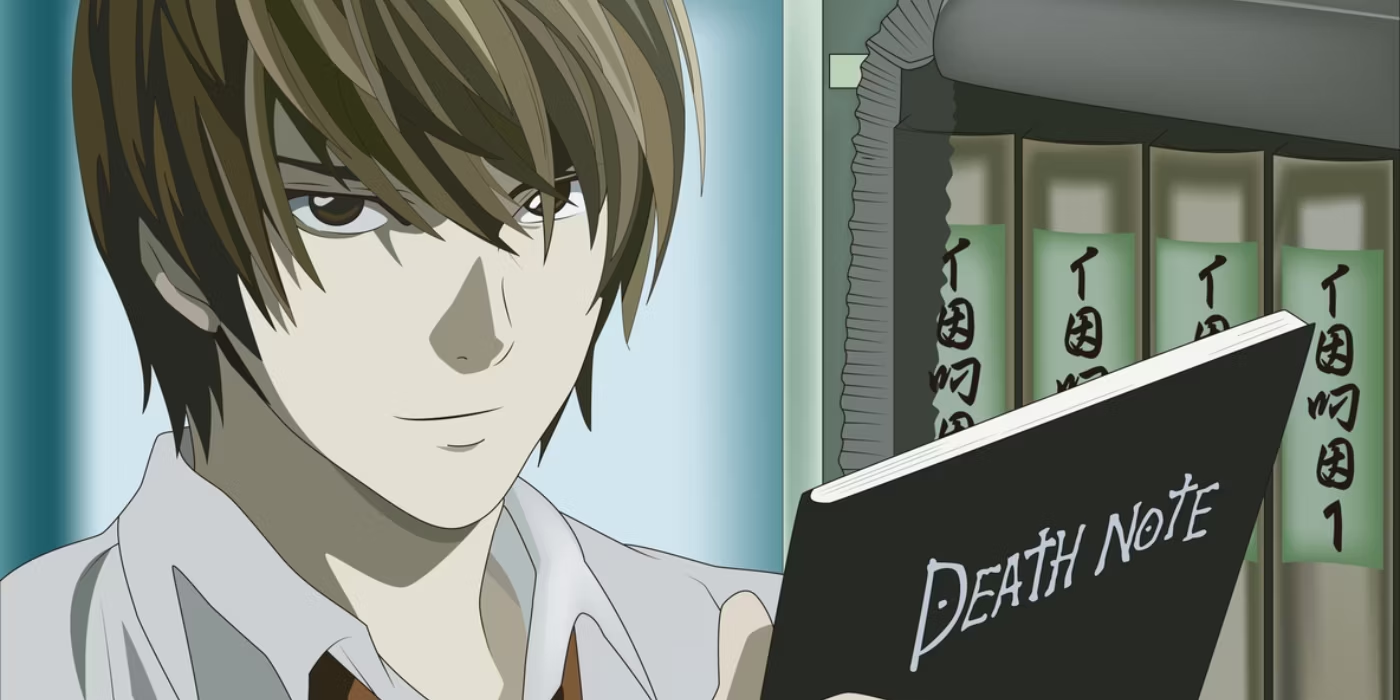

И наш Светозар Кирыч незамедлительно вставил свои пять <s>шекелей</s> копеек. Просто прежде чем делать рекомендательную систему, разве не стоит ответить на глвынй вопрос: "А почему мы стали школой одного курса? И вообще так ли это на самом деле?"
1. У нас есть 127 различных курсов, причем по легенде у нас есть только один курс хедлайнер и еще пара-тройка, неплохо продающихся курсов. Что делать с остальными? Стоит ли оставить всё как есть, поработать над улучшением курсов или вообще закрыть их и не тратить ресурсы понапрасну. Чтобы ответить на эти вопросы нам необходимо разработать оценку эффективности наших курсов и провести методический аудит. Так как единого принятого стандарта на рынке нет, а требования пользователей к качеству онлайн-образования с каждым годом становятся всё строже, нужно успевать реагировать и разрабатывать свои новые методы оценки. Однако, в онлайн-образовании принято ориентироваться на такие показатели качества, как NPS (аббревиатура от английского понятия Net Promoter Score. Эта метрика замеряет уровень лояльности клиентов, готовности рекомендовать продукт другим.), CSI (аббревиатура от английского термина Customer Satisfaction Index, в переводе — индекс удовлетворённости клиентов.) и COR (или Completion Rate, переводится с английского как «индекс доходимости». Метрика показывает, какой процент студентов дошёл до финала обучения). Но в каждой образовательной компании их считают по-разному.
2. По идее у каждого курса, каждой программы есть своя команда из продюсеров и методистов, авторов и преподавателей и кураторов, которые все вместе влияют на наполнение курса и в целом на весь образовательный процесс. Поэтому система оценки качества должна отвечать следующим требованиям: все в команде знают, каким должен быть качественный курс; есть специалисты, которые понимают, как именно это качество отследить и измерить; у человеческого фактора нет шансов критически повлиять на качество продукта.
3. Поэтому, если у нас в компании такой системы нет, а судя по всему ее нет, то над ее разработкой должны работать следующие отделы: учебно-методический отдел, который выдвигает гипотезы о причинах низкого качества и отбирает курсы, которые надо переработать в первую очередь; отдел аналитики, который помогает определить, что влияет на качество (это мы с Беней, и вопросы нам задали судя по всему не то чтобы неверные, скорее несвоевременные, для начала надо разобраться в первопричине такого положения дел); направления обучения, которые понимают общее положение дел и динамику по качеству, проверяют, сработали ли их гипотезы по улучшению качества, приоритизируют свои ресурсы.
4. Стандартные показатели — NPS, CSI, COR — верхнеуровневые: они не показывают проблемные места и не покрывают все важные аспекты образовательного продукта. Мы измеряем и следим за ними, но для полноценной оценки их не хватает. К тому же они недостаточно репрезентативны, так как каждая платформа считает их по-разному в отношении разных сегментов аудитории. Кстати, насчет аудитории, мы в своей рекомендательной системе совсем не учли структуру нашей аудитории, кому и что мы будем предлагать (в зависимости от целей, пола, возраста и других параметров аудитории, у нее могут отличаться требования и предпочтения).
5. Исходя из вышесказанного, есть смысл подумать над концепцией "выгоды и свойства". Какую выгоду приобретает студент при покупке продукта и какими свойствами продукта эта выгода обеспечивается. 
Выгоды, и соответствующие метрики для замера могут выглядить следующим образом. 
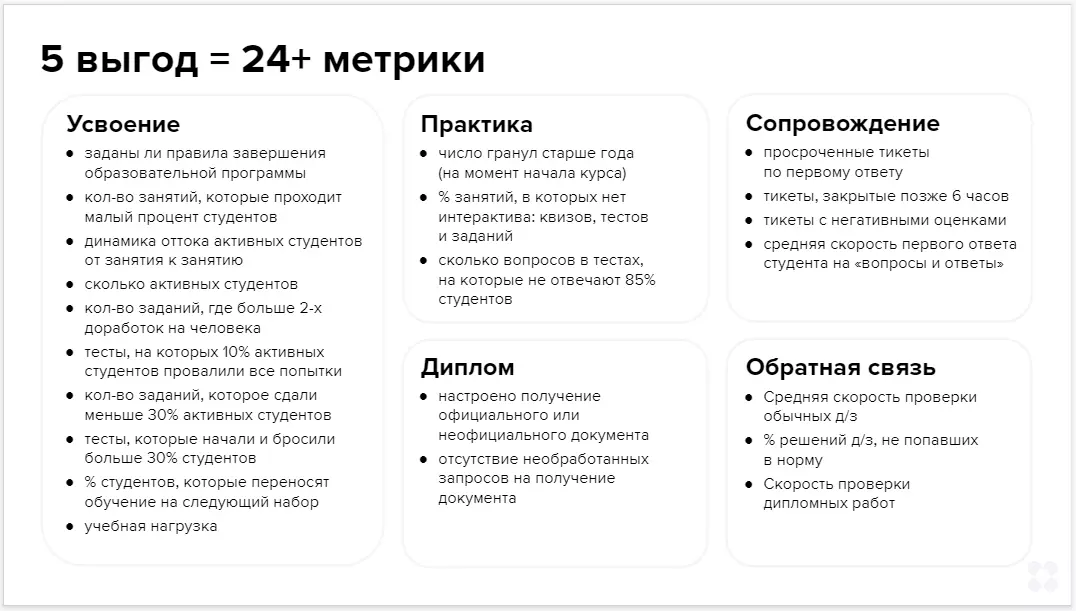

6. За каждую выгоду для пользователя курс получает максимум 20 баллов например. По каждому набору студентов на каждом онлайн-курсе измеряется индекс качества от 0 до 100 баллов. Они интерпретируются следующим образом:
больше 70 — качество в норме;
60‒70 — есть над чем поработать;
меньше 60 — качество ниже нормы, стоит обратить внимание.
И таким образом, на основе такого анализа мы сможем сделать и более информативный визуальный отчет, который визуально будет показывать рост и падение наших индексов по продуктам, и принимать соответсвующие меры. Предложенная система естественно это один из вариантов, который нужно адаптировать конкретно под нашу школу и более детально обсудить ее с другими отделами. 

7. И еще нужно будет иметь ввиду с чьей стороны будем смотреть на наши образовательные продукты и оценивать успешносность наших курсов, и соответственно метрики считать. 
С точки зрения студента курс полезен, когда позволяет достичь цели, ради которой он был приобретён. Обычно эта цель находится за границами обучения: например, получить повышение или сменить профессию.
С точки зрения методиста курс успешен, когда после обучения произошли изменения установок и поведения человека, которые можно измерить. Например, после прохождения курса по программе Excel сотрудники стали тратить на операции с формулами на 30% меньше времени.
С точки зрения организатора обучения образовательный продукт эффективен, когда ресурсы, которые вложены в его создание и сопровождение, соразмерны выгоде, полученной в результате.
Когда речь идёт о корпоративном обучении, желаемые результаты для методиста и организатора обучения совпадают: заказчик (например, руководитель компании) заинтересован в том, чтобы сотрудники после прохождения курса или тренинга стали работать эффективнее и чтобы затраты на обучение были экономически оправданы.

8. Вернемся к нашему методическому аудиту. Он включает в себя 7 основных подгрупп вопросов, по которым мы будем проверять наших методистов. 
<details><summary>I. Понимание целевой аудитории курса организаторами обучения.</summary>
<p>Нужно посмотреть анкеты участников курса, результаты кастдева, изучить собранную от выпускников обратную связь. Это покажет, насколько чётко курс ведёт к нужным результатам конкретную целевую аудиторию с определёнными знаниями, навыками и возможностями учиться.</p></details>
<details><summary>II. Методическая концепция курса и логики обучения.</summary>
<p>- Описаны ли финальные и промежуточные цели обучения?
- Как выстроена логика обучения и понятна ли она?
- На какие темы и подтемы делится учебная программа и почему именно так?
- Какой смысл заложен в заголовках и хорошо ли они сформулированы?
- Какова общая длительность обучения и почему она именно такая?
- Равномерно ли распределена учебная нагрузка, есть ли перерывы?</p></details>
<details><summary>III. Образовательная среда курса.</summary>
<p>- Есть ли у учащегося возможность взаимодействовать с другими студентами, преподавателями?
- Предусмотрено ли вводное занятие?
- Даются ли учащимся рекомендации о том, как эффективно учиться и работать с внутренней мотивацией?
- Ясно ли, кому и когда можно задавать вопросы?
- Удобен ли интерфейс выбранной платформы, понятно ли структурирован курс со всеми его элементами и средствами коммуникаций, всё ли работает (например, видео, ссылки, интерактивные элементы)?
- Понятно ли, как получать обучающий контент, выполнять и сдавать практические задания, куда приходит обратная связь от проверяющего?
- Есть ли у самого студента возможность оставить обратную связь и как с ней работают организаторы обучения?
- Можно ли упростить образовательную среду?
- Доступно ли обучение на мобильных устройствах и удобно ли проходить курс в таком виде?</p></details>
<details><summary>IV. Качество образовательного контента.</summary>
<p>- Какой формат учебных материалов выбран и почему?
- Насколько удобно воспринимать информацию? Тут оценивается шрифт, контрастность и так далее.
- Используется ли общий стиль или шаблон для представления контента?
- Каков объём основной теоретической части и дополнительных материалов, почему именно такой?
- Есть ли у занятий единая структура и если да, то что она в себя включает?
- Приводятся ли реальные кейсы?
- Рекомендуется ли дополнительная литература?
- Что мы знаем о реакции учащихся на контент курса?
- Что мы знаем о реакции студентов на преподавателей и подачу материала?
- Насколько качественно преподаватель доносит содержание курса в выбранном формате (оценивается речь, стиль общения, качество презентационного материала, звука и видео) и как взаимодействует с учащимися?
- Можно ли сократить объём теории и самостоятельного обучения, чтобы при этом не пострадала практика?
- Понятно ли студентам, какой материал надо изучить обязательно, а какой — по желанию?
- Нет ли ошибок и опечаток в текстах курса?</p></details>
<details><summary>V. Качество практических занятий.</summary>
<p> - Какие способы оценки полученных знаний выбраны (промежуточные и финальные)?
- Какова интенсивность выполнения практических заданий и справляются ли с этим студенты?
- Достаточно ли теоретического контента для выполнения заданий?
- Как структурированы домашние задания и инструкции к выполнению практики?
- Каков формат обратной связи?
- Что мы знаем о реакции учащихся на практику?
- Насколько практические задания соответствуют реальным задачам, с которыми затем столкнётся студент?
- Понятна ли учащемуся система оценивания выполненных заданий?</p></details>
<details><summary>VI. Данные, полученные во время обучения предыдущих потоков.</summary>
<p>- выполнение промежуточных и финальных домашних заданий, спроектированных на основе учебных целей (хорошо, если аналитика данных LMS онлайн-платформы позволяет собрать подробную информацию);
- скорость ответов на вопросы учащихся;
- скорость проверки домашних заданий;
- посещаемость вебинаров или просмотр другого учебного контента;
- CSI — удовлетворённость процессом, содержанием, результатами обучения (оценивается с помощью обратной связи через анкеты и интервью);
- NPS — лояльность студентов, готовность рекомендовать курс другим;
- COR — доходимость курса до конца;
- процент возвратов в случаях, когда студентам не подошёл сам курс, формат обучения или что-то ещё;
- процент устроенных на стажировку студентов или трудоустроенных выпускников;
- процент положительных отзывов.</p></details>
<details><summary>VII. Сопровождение обучения.</summary>
<p>- Как распределены роли в сопровождении курса и достаточно ли ресурсов для масштабирования — запуска новых потоков, одновременного обучения нескольких потоков студентов?</p></details>



Подводя итог, как видим нам необходимо провести очень большой объем подготовительной аналитической работы. Иначе наша рекомендательная система в долгосрочной перспективе может дать сбой, потому что положительный эффект от ее внедрения может оказаться случайным и временным. Ведь в итоге мы не учли, что и кому мы будем рекомендовать, и самое главное не разобрались в причине почему же мы школа одного курса - "Питон для различных бытовых приборов".  Средний чек мы на время возможно увеличим, но увеличится вообще общая прибыль нашей школы в долгосрочной перспективе, ведь у нас есть 127 различных курсов, непонятно какого качества. 

Еще раз повторюсь о необходимости создания измеримой и объективной системы контроля качества наших курсов. 

И последний вопрос к организационно-методическому отделу: "А с какой такой любовью они делали все курсы?" .....Возможно с любовью к друг к другу, ну там авторы, методисты, кураторы и менторы, продюсеры и прочие вот брали и любили друг друга, в 2017-2018 гг. так можно было делать=) полиаморию никто не запрещал и действительно курсы то делали с любовью. И видимо, задачей аналитического отдела является еще и отслеживание направления любви своих коллег из других отделов, и придание ей нужного направления=)))